# Questions

### Model insights and preliminary analysis of dataset

There are certain outliers with exceptionally hight debt ratio and revolving utilization of unsecured lines, which did not have an impact on default probability. I expected that these higher values would contribute to higher defaults. Since they did not, it does seem like values entered by mistake.

There is collinearity between the variable NumberOfTime30-59DaysPastDueNotWorse and NumberOfTimes90DaysLate. This indicates behaviour of recurring late payments. I do find it strange, however, that NumberOfTime60-89DaysPastDueNotWorse is not linearly related to these 2 variables as well, and will explore it given more time and access to subject matter experts in this area.

I also binned MonthlyIncome values and converted it to an ordinal categorical variable. Although one would expect default probabilities to go down with higher income, I observed that default probabilities only decreased slightly for higher income groups. Income ranges are also easier to predict, and this was done for the missing values.

---


### How did I evaluate my model, and why I chose such a technique

I evaluated my models based on AUC-ROC - the area under the Receiver Operating Curve. This metric is suitable for a class imbalance problem as opposed to accuracy, which will be falsely inflated due to higher true positives from the majority class. 

If I had more time, I would look at tuning the hyperparameters of an xgboost model, but I think that a random forest classifier suits this problem particularly well with an absence of one-hot variables. It does also make sense to split the data based on certain cut-off ranges of income bracket and frequency of late payments. 

Some error analysis into important features would be nice if I had more time.

---

### What is AUC? Why was it used as the evaluation metric for such a problem? What other suitable metrics are there?

The AUC indicates how well the model is able to distinguish between positive and negative classes. The False Positive rate indicates how many negatives are predicted as positives. By plotting the curve, it shows us if there is a good trade-off between a high true positive rate (recall) and the false positive rate (directly related to precision). 

By plotting it this way, it also shows us how well the model performs compared to a baseline of simply predicting the majority class. This is done by looking at how close the curve is at attaining the ideal of 0 false positive rate, and perfect true positive rate. 

Other suitable metrics will include F1-score. It indicates the optimal threshold which makes the best trade-off between precision and recall. 

I think the corresponding recall value here is very important. It gives the bank some measure of the cases of default that might be missed if this model is used.

---

### Kaggle leaderboard of top 100 or higher

Top 100 scores have a cut-off of 86.723%, and I do still have some ways to go with a top model score of 86.2%. 

---

## 1: Data cleaning 

#### Summary of data cleaning steps:

- MonthlyIncome values transformed into an ordinal variable (1 to 3 in ascending order of 'wealthiness')
- Missing MonthlyIncome values predicted by a LogisticRegression model
- Missing values in number of dependents mapped to 0 as an assumption
- Removed outliers from DebtRatio and RevolvingUtilizationOfUnsecuredLines

In [138]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [100]:
full_train_path = "cs-training.csv"

full_train = pd.read_csv(full_train_path)
full_train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [101]:
full_train.drop(columns=['Unnamed: 0'], inplace = True)

In [4]:
full_train.info()
# number of dependents and monthly income has missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


In [5]:
full_train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


Bigger standard deviation values indicate outliers, in particular for RevolvingUtilizationOfUnsecuredLines and DebtRatio.

In [7]:
full_train.SeriousDlqin2yrs.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

In [97]:
10026/139974

0.07162758798062498

In [130]:
def default_proba(dataframe):
    counts = dataframe.SeriousDlqin2yrs.value_counts()
    pos_count = counts.get(1, 0)
    prob = round(pos_count / counts[0], 3)
    print(f"Number of positive samples: {pos_count}")
    print(f"Probability of default: {prob}")

The minority class percentage is about 7%, so this is an important number to look out for when evaluating if outliers should be dropped, or when considering if certain groups are more likely to default than others.


### 1.1: Handling outliers in RevolvingUtilizationofUnsecuredLines

RL (revolving utilization of unsecured lines) does contain some outliers. This column is a percentage value as mentioned in the data_dict, but 

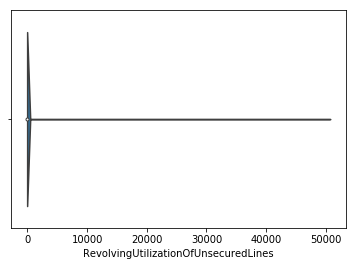

In [103]:
sns.violinplot(full_train.RevolvingUtilizationOfUnsecuredLines)

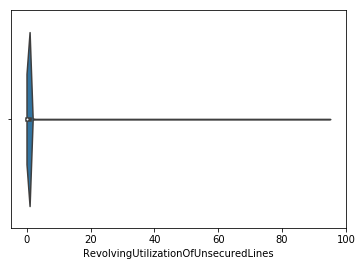

In [107]:
rl_less_than_100 = full_train[(full_train.RevolvingUtilizationOfUnsecuredLines <= 100)]
sns.violinplot(rl_less_than_100.RevolvingUtilizationOfUnsecuredLines)

In [114]:
default_proba(rl_less_than_100)

Probability of default: 0.072


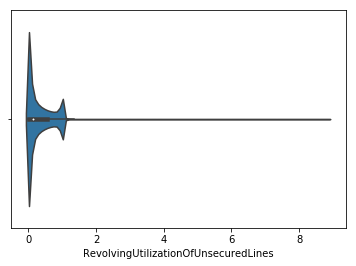

In [116]:
rl_less_than_10 = full_train[(full_train.RevolvingUtilizationOfUnsecuredLines <= 10)]
sns.violinplot(rl_less_than_10.RevolvingUtilizationOfUnsecuredLines)

In [123]:
default_proba(rl_less_than_10)

Number of positive samples: 10009
Probability of default: 0.072


Logically, I expected that having more unsecured lines likely means higher probability of default and financial difficulty. 
I was wondering if removing outliers with large RL values would lower the probability of default.
Since this isn't the case, we can conclude that these outliers don't have a s significant impact on defaulting.

In [125]:
unsecured_lines_outliers = full_train[(full_train.RevolvingUtilizationOfUnsecuredLines > 10)]
default_proba(unsecured_lines_outliers)

Number of positive samples: 17
Probability of default: 0.076


In [14]:
full_train.drop(index=unsecured_lines_outliers.index, inplace=True)

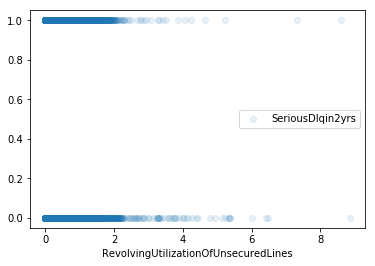

In [15]:
full_train.plot(x='RevolvingUtilizationOfUnsecuredLines', y='SeriousDlqin2yrs', style='o', alpha=0.1)

Distribution of age looks okay at first glance. People who default do seem to come from a variety of ages. 

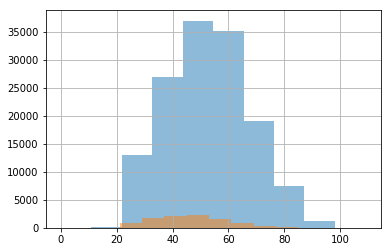

In [121]:
positive_class = full_train[(full_train.SeriousDlqin2yrs == 1)]
negative_class = full_train[(full_train.SeriousDlqin2yrs == 0)]

negative_class.age.hist(alpha=0.5)
positive_class.age.hist(alpha=0.5)

### 1.2: Removing outliers for DebtRatio

Outliers above 40,000 or 50,000 are not the ones defaulting, oddly, given the extreme amount of leverage they have.

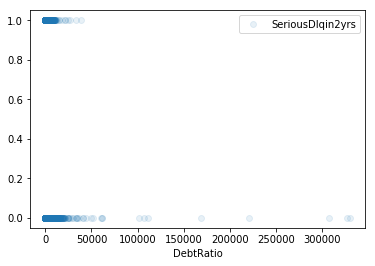

In [18]:
full_train.plot(x='DebtRatio', y='SeriousDlqin2yrs', style='o', alpha=0.1)
# outliers/data-entry errors above 40k or 50k don't have an impact on default

In [126]:
dr_more_than_20000 = full_train[(full_train.DebtRatio > 20000)]
default_proba(dr_more_than_20000)

Number of positive samples: 7
Probability of default: 0.2


These samples might be very far from the sample mean DebtRatio, but the probability of default is high compared to the rest of the sample. Keep these for now.

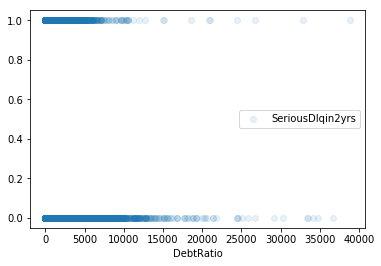

In [19]:
full_train[(full_train.DebtRatio < 40000)].plot(x='DebtRatio', y='SeriousDlqin2yrs', style='o', alpha=0.1)

In [131]:
dr_outliers = full_train[(full_train.DebtRatio > 40000)]
default_proba(dr_outliers)

Number of positive samples: 0
Probability of default: 0.0


In [22]:
full_train.drop(index=dr_outliers.index, inplace=True)

### 1.3: Other columns

Other columns have much smaller standard deviation values, but let's see if any of these have a strong relationship with defaulting.

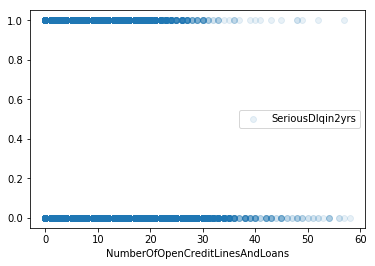

In [24]:
full_train.plot(x='NumberOfOpenCreditLinesAndLoans', y='SeriousDlqin2yrs', style='o', alpha=0.1)

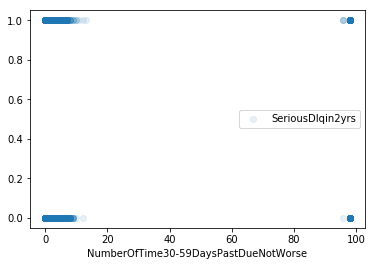

In [25]:
full_train.plot(x='NumberOfTime30-59DaysPastDueNotWorse', y='SeriousDlqin2yrs', style='o', alpha=0.1)

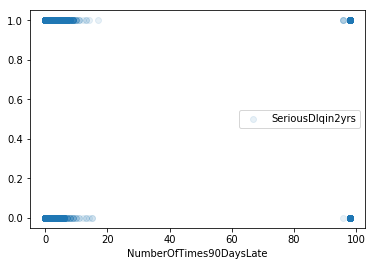

In [26]:
full_train.plot(x='NumberOfTimes90DaysLate', y='SeriousDlqin2yrs', style='o', alpha=0.1)

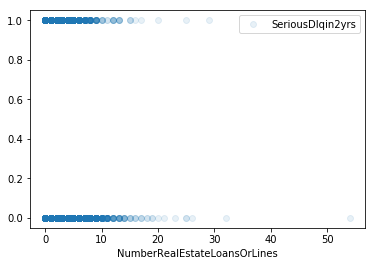

In [27]:
full_train.plot(x='NumberRealEstateLoansOrLines', y='SeriousDlqin2yrs', style='o', alpha=0.1)

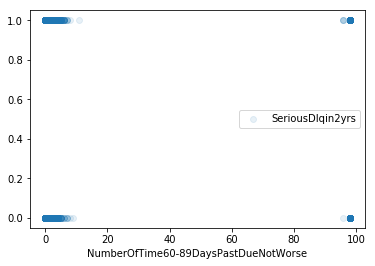

In [28]:
full_train.plot(x='NumberOfTime60-89DaysPastDueNotWorse', y='SeriousDlqin2yrs', style='o', alpha=0.1)

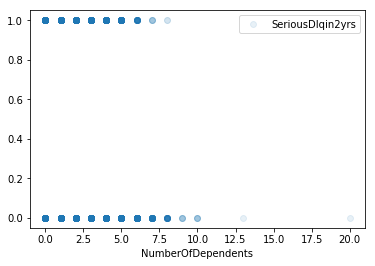

In [29]:
full_train.plot(x='NumberOfDependents', y='SeriousDlqin2yrs', style='o', alpha=0.1)

Removing samples with number of dependents > 12 will not have an impact on minority class percentage.

In [30]:
dep_outliers = full_train[(full_train.NumberOfDependents > 12)]
dep_outliers.SeriousDlqin2yrs.value_counts()

full_train.drop(index=dep_outliers.index, inplace=True)

In [31]:
full_train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,149741.000000,149741.000000,149741.000000,149741.000000,149741.000000,1.200910e+05,149741.000000,149741.000000,149741.000000,149741.000000,145832.000000
mean,0.066842,0.322750,52.296946,0.421428,338.800153,6.667829e+03,8.456782,0.266293,1.017724,0.240656,0.757159
std,0.249749,0.366745,14.772071,4.196326,1100.787102,1.439298e+04,5.147304,4.172833,1.128291,4.158705,1.113632
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029785,41.000000,0.000000,0.174951,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.153535,52.000000,0.000000,0.366448,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.555897,63.000000,0.000000,0.866596,8.241000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,8.851852,109.000000,98.000000,38793.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,10.000000


In [132]:
default_proba(full_train)

Number of positive samples: 10026
Probability of default: 0.072


As a sanity check, probability of default hasn't changed after removing the outliers.

### 1.4: Should I drop the missing values in the MonthlyIncome predictor?



In [135]:
has_income_value = full_train[(pd.notnull(full_train.MonthlyIncome))]
default_proba(has_income_value)

Number of positive samples: 8357
Probability of default: 0.075


In [137]:
no_income_value = full_train[(pd.isnull(full_train.MonthlyIncome))]
default_proba(no_income_value)

Number of positive samples: 1669
Probability of default: 0.059


#### Conclusion

Dropping these values won't make an impact on the minority class percentage, but that's still dropping ~10% of our minority class samples. I've decided not to drop these for now, but if I had more time I would compare results from a training data set before and after dropping.

### 1.5: Check for collinearity

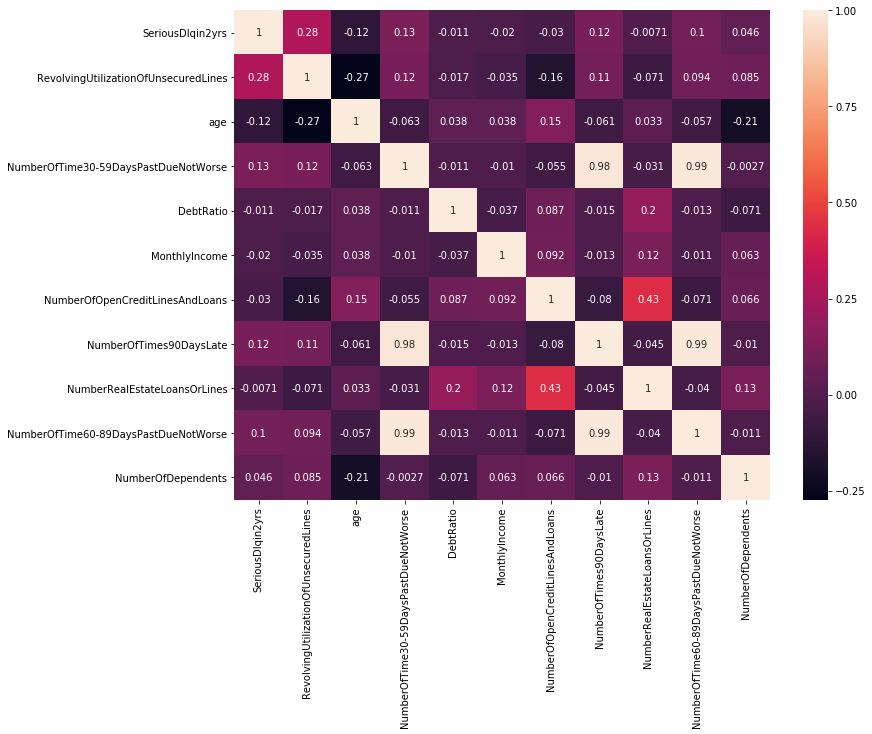

In [38]:
plt.figure(figsize=(12, 9))
corr_mat = full_train.corr()
sns.heatmap(corr_mat, annot=True)

Strong correlation between Number of times 30-59 days due not worst, and Number of times 90 days late


Which one to drop would probably depend on contextual knowledge. 
- What sort of policies does a bank have in place to handle groups who are 30-59 days late for payment, and prevent them from falling into the next tier (90 days late)
- Is it in the bank's interest to help people like that? - balance between profits earned from loan interest rates, and the ability of people in these groups to repay 

Those who are 90 days late were previously in the 30-59 days late group, so let's drop the 90 days predictor instead

### 1.6: Bin monthly income 

Initial plan was to train a linear regression model on other predictor values, check R^2 value on a hold-out set, and predict on samples with missing monthly income values.

Such a model gives us the approx monthly income for each sample. 
However, looking at the 2 plots below, most people who default fall in the more middle-class bracket of less than 20k a month. 
This indicates that its more important to know which income bracket people fall into when looking at probability of default.

After deciding on how to bin monthly income, we will then have monthly income as an ordinal categorical variable.

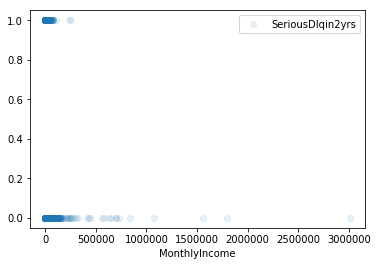

In [39]:
# interpolate missing monthly income values using other columns as predictors, after filtering outliers first

full_train.plot(x='MonthlyIncome', y='SeriousDlqin2yrs', style='o', alpha=0.1)

(array([1431., 3183., 1964.,  885.,  422.,  185.,   99.,   51.,   37.,
          17.]),
 array([    0.,  2470.,  4940.,  7410.,  9880., 12350., 14820., 17290.,
        19760., 22230., 24700.]),
 <a list of 10 Patch objects>)

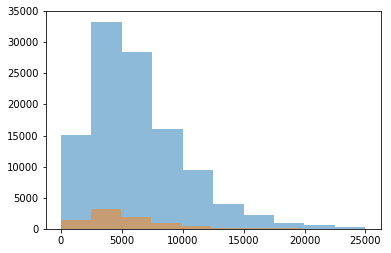

In [40]:
lower_income = full_train[(full_train.MonthlyIncome < 25000)]

plt.hist(lower_income[(lower_income.SeriousDlqin2yrs == 0)].MonthlyIncome, alpha= 0.5)
plt.hist(lower_income[(lower_income.SeriousDlqin2yrs == 1)].MonthlyIncome, alpha= 0.5)

Some potentially suitable bins to place people into: 0 to 5000 (exclusive), 5000 to 10000 exclusive, 10,000 to 15,000 exclusive, and the rest of the ultra-rich.

In [41]:
income_data = full_train.copy()
income_data.drop(columns=['NumberOfTimes90DaysLate', 'SeriousDlqin2yrs'], inplace=True)

In [42]:
full_train[(full_train.MonthlyIncome < 5000)].SeriousDlqin2yrs.value_counts()

# 9.5% of people in this bracket default

0    48408
1     4643
Name: SeriousDlqin2yrs, dtype: int64

In [43]:
middle1_data = full_train[(full_train.MonthlyIncome >= 5000) & (full_train.MonthlyIncome < 10000)]
middle1_data.SeriousDlqin2yrs.value_counts()

# ~6.4% of people in this bracket default

0    44461
1     2843
Name: SeriousDlqin2yrs, dtype: int64

In [44]:
middle2_data = full_train[(full_train.MonthlyIncome >= 10000) & (full_train.MonthlyIncome < 20000)]
middle2_data.SeriousDlqin2yrs.value_counts()

# ~4.4% of people in this bracket default

0    16679
1      735
Name: SeriousDlqin2yrs, dtype: int64

In [45]:
rich_data = full_train[(full_train.MonthlyIncome >= 20000)]
rich_data.SeriousDlqin2yrs.value_counts()

# ~5.4% of people in this bracket default

0    2201
1     121
Name: SeriousDlqin2yrs, dtype: int64

In [46]:
def lower(income): return 0 <= income < 5000
def middle(income): return 5000 <= income < 20000
def rich(income): return income >= 20000

def income_category(income):
    if lower(income):
        return 1
    elif middle(income):
        return 2
    else:
        return 3
    
test_size = 0.3
random_seed = 47

### 1.7: Predict monthly income category for samples with missing value

In [47]:
categorical_income = [income_category(income) for income in income_data.MonthlyIncome]

X = income_data.drop(columns=['MonthlyIncome', 'NumberOfDependents'])
y = categorical_income

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, 
                                                    random_state=random_seed)

In [49]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty='l2', random_state=random_seed)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=47, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
logreg.score(X_train, y_train)

0.6957583621133775

In [51]:
y_pred = logreg.predict(X_test)

In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.60      0.58      0.59     16020
          2       0.69      0.81      0.75     19231
          3       0.93      0.66      0.77      9672

avg / total       0.71      0.70      0.70     44923



In [53]:
samples_with_missing_income = full_train[(pd.isnull(full_train.MonthlyIncome))]
process_samples = samples_with_missing_income.drop(columns=['MonthlyIncome', 'NumberOfDependents',
                                                           'NumberOfTimes90DaysLate', 'SeriousDlqin2yrs'])
pred_income_category = logreg.predict(process_samples)

In [54]:
samples_with_missing_income['income_category'] = pred_income_category

/Users/cjiahui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [55]:
samples_with_income = full_train[(pd.notnull(full_train.MonthlyIncome))]
samples_with_income['income_category'] = [income_category(income) for income in samples_with_income.MonthlyIncome]

/Users/cjiahui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [56]:
training = pd.concat([samples_with_missing_income, samples_with_income])
training.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,income_category
6,0,0.305682,57,0,5710.0,NaN,8,0,3,0,0.0,3
8,0,0.116951,27,0,46.0,NaN,2,0,0,0,NaN,1
16,0,0.061086,78,0,2058.0,NaN,10,0,2,0,0.0,3
32,0,0.083418,62,0,977.0,NaN,6,0,1,0,0.0,3
41,0,0.072898,81,0,75.0,NaN,7,0,0,0,0.0,1


(array([5264.,    0.,    0.,    0.,    0., 3579.,    0.,    0.,    0.,
        1166.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

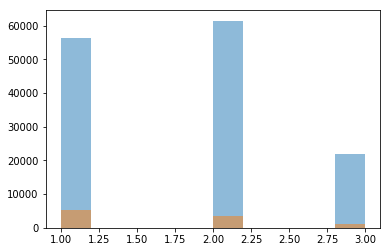

In [57]:
plt.hist(training[(training.SeriousDlqin2yrs == 0)].income_category, alpha= 0.5)
plt.hist(training[(training.SeriousDlqin2yrs == 1)].income_category, alpha= 0.5)

(array([4643.,    0.,    0.,    0.,    0., 3578.,    0.,    0.,    0.,
         121.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

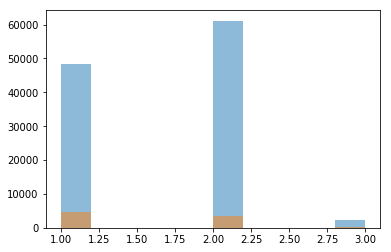

In [58]:
plt.hist(samples_with_income[(samples_with_income.SeriousDlqin2yrs == 0)].income_category, alpha= 0.5)
plt.hist(samples_with_income[(samples_with_income.SeriousDlqin2yrs == 1)].income_category, alpha= 0.5)

Distributions between the two look roughly similar although there are more defaults in the income category 3 bin. 

To improve this in the future, one could apply a Smirnov test here to roughly check how similar the cumulative dist functions are across the categories for the positive class.

In [59]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149741 entries, 6 to 149999
Data columns (total 12 columns):
SeriousDlqin2yrs                        149741 non-null int64
RevolvingUtilizationOfUnsecuredLines    149741 non-null float64
age                                     149741 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149741 non-null int64
DebtRatio                               149741 non-null float64
MonthlyIncome                           120091 non-null float64
NumberOfOpenCreditLinesAndLoans         149741 non-null int64
NumberOfTimes90DaysLate                 149741 non-null int64
NumberRealEstateLoansOrLines            149741 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149741 non-null int64
NumberOfDependents                      145832 non-null float64
income_category                         149741 non-null int64
dtypes: float64(4), int64(8)
memory usage: 14.9 MB


(array([5.086e+03, 1.931e+03, 1.582e+03, 8.360e+02, 0.000e+00, 2.960e+02,
        6.800e+01, 2.400e+01, 5.000e+00, 2.000e+00]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

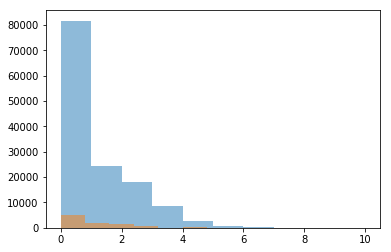

In [60]:
data_with_dependents = training.copy()
data_with_dependents.dropna(subset=['NumberOfDependents'], inplace=True)

plt.hist(data_with_dependents[(data_with_dependents.SeriousDlqin2yrs == 0)].NumberOfDependents, alpha= 0.5)
plt.hist(data_with_dependents[(data_with_dependents.SeriousDlqin2yrs == 1)].NumberOfDependents, alpha= 0.5)

In [61]:
training[(pd.isnull(training.NumberOfDependents))].SeriousDlqin2yrs.value_counts()

0    3730
1     179
Name: SeriousDlqin2yrs, dtype: int64

Instead of dropping samples where number of dependents is missing, let's assume that its 0 since its left blank.

In [62]:
training['NumberOfDependentsFull'] = [no if pd.notnull(no) else 0. for no in training.NumberOfDependents]

### 1.8: Quick check

-----RevolvingUtilizationOfUnsecuredLines------


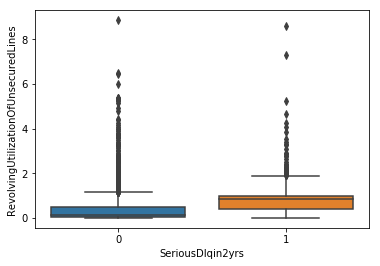

-----age------


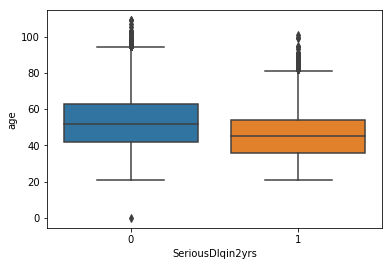

-----NumberOfTime30-59DaysPastDueNotWorse------


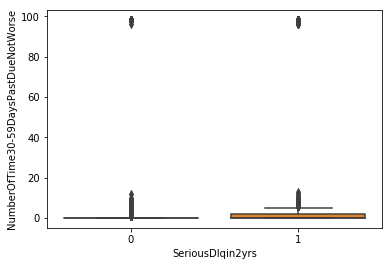

-----DebtRatio------


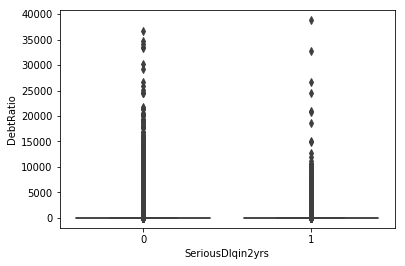

-----NumberOfOpenCreditLinesAndLoans------


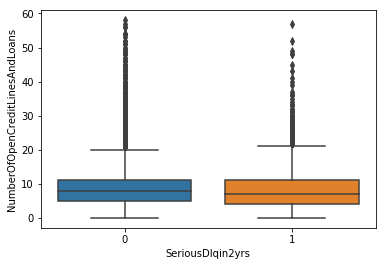

-----NumberOfTimes90DaysLate------


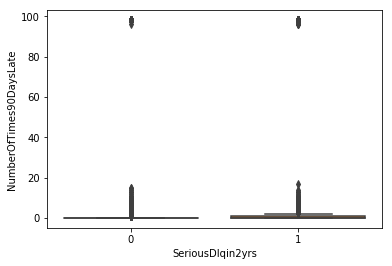

-----NumberRealEstateLoansOrLines------


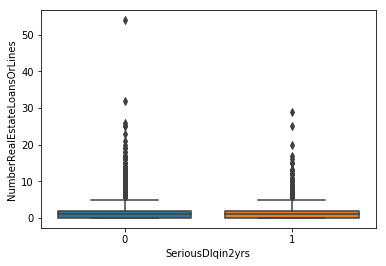

-----NumberOfTime60-89DaysPastDueNotWorse------


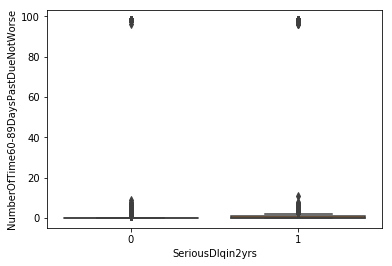

-----income_category------


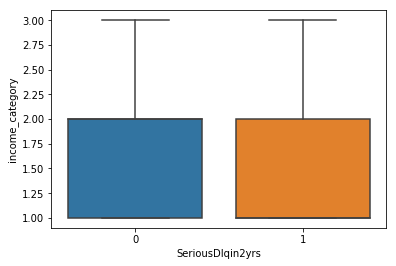

-----NumberOfDependentsFull------


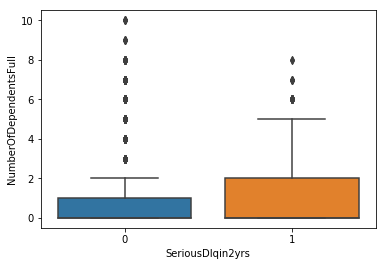

In [85]:
ignore = {'MonthlyIncome', 'NumberOfDependents', 'SeriousDlqin2yrs'}

for col in training:
    
    if col in ignore:
        continue
    
    print(f"-----{col}------")
    sns.boxplot(data=training, x='SeriousDlqin2yrs', y=col)
    plt.show()

### Preparation of training data for predicting default probability complete

Summary of above steps:

- MonthlyIncome values transformed into an ordinal variable (1 to 3 in ascending order of 'wealthiness')
- missing MonthlyIncome values predicted by a LogisticRegression model
- missing values in number of dependents mapped to 0 as an assumption
- removed outliers from DebtRatio and RevolvingUtilizationOfUnsecuredLines


## 2: Training models to predict default probability

In [63]:
default_data = training.copy()
default_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,income_category,NumberOfDependentsFull
6,0,0.305682,57,0,5710.0,NaN,8,0,3,0,0.0,3,0.0
8,0,0.116951,27,0,46.0,NaN,2,0,0,0,NaN,1,0.0
16,0,0.061086,78,0,2058.0,NaN,10,0,2,0,0.0,3,0.0
32,0,0.083418,62,0,977.0,NaN,6,0,1,0,0.0,3,0.0
41,0,0.072898,81,0,75.0,NaN,7,0,0,0,0.0,1,0.0


In [64]:
train_default = default_data.drop(columns=['MonthlyIncome', 'NumberOfDependents', 'SeriousDlqin2yrs'])
outcome_default = default_data.SeriousDlqin2yrs.map(int)

In [65]:
default_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149741 entries, 6 to 149999
Data columns (total 13 columns):
SeriousDlqin2yrs                        149741 non-null int64
RevolvingUtilizationOfUnsecuredLines    149741 non-null float64
age                                     149741 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    149741 non-null int64
DebtRatio                               149741 non-null float64
MonthlyIncome                           120091 non-null float64
NumberOfOpenCreditLinesAndLoans         149741 non-null int64
NumberOfTimes90DaysLate                 149741 non-null int64
NumberRealEstateLoansOrLines            149741 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    149741 non-null int64
NumberOfDependents                      145832 non-null float64
income_category                         149741 non-null int64
NumberOfDependentsFull                  149741 non-null float64
dtypes: float64(5), int64(8)
memory usage: 16.0 MB


In [66]:
X_train, X_test, y_train, y_test = train_test_split(train_default, outcome_default, test_size = test_size, 
                                                    random_state=random_seed)

### 2.1: Utility functions for model training and evaluation

Another metric that would be useful is the F1 score of the minority class. 
For every predicted probability, I set a threshold to classify it into the positive or negative class.
The F1 score is then calculated for a range of different threshold values to find the best trade-off between precision and recall. 

This is similar to finding the point on the ROC curve which best maximises true positive rate, and minimises false positive rate.

In [75]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
import numpy as np

def train_and_eval(model, x_train, x_test, y_train, y_test):
    
    model.fit(x_train, y_train)
    print(f"Model trained!")
    
    y_pred = model.predict_proba(x_test)
    
    threshold_range_f1(y_pred[:,1], y_test, thresh_start_end=(0.2,0.8))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % auc(fpr, tpr))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return model

def threshold_range_f1(y_prob, y_test, thresh_start_end):
    start, end = thresh_start_end
    threshold = start
    increment = 0.1
    
    while threshold <= end: 
        threshold_f1(y_prob, y_test, round(threshold, 1))
        threshold += increment
        print("-------")
        
def threshold_f1(y_prob, y_test, threshold=0.5):
    y_pred = np.where(y_prob >= threshold, 1, 0)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    print(f"THRESHOLD: {threshold}")
    print(f"P: {round(p,3)}, R: {round(r,3)}, F1: {round(f1,3)}")

### 2.2: Random Forest classifier

Model trained!
THRESHOLD: 0.2
P: 0.328, R: 0.524, F1: 0.403
-------
THRESHOLD: 0.3
P: 0.406, R: 0.407, F1: 0.406
-------
THRESHOLD: 0.4
P: 0.473, R: 0.296, F1: 0.365
-------
THRESHOLD: 0.5
P: 0.527, R: 0.198, F1: 0.288
-------
THRESHOLD: 0.6
P: 0.579, R: 0.112, F1: 0.188
-------
THRESHOLD: 0.7
P: 0.616, R: 0.044, F1: 0.082
-------
THRESHOLD: 0.8
P: 0.603, R: 0.013, F1: 0.025
-------


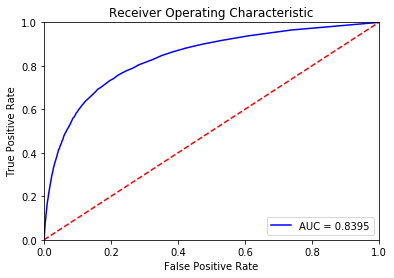

In [74]:
from sklearn.ensemble import RandomForestClassifier

max_depth = None
no_trees = 200

rfc = RandomForestClassifier(n_estimators=no_trees, random_state=random_seed, max_depth=max_depth)
rfc = train_and_eval(rfc, X_train, X_test, y_train, y_test)

In [87]:
from sklearn.model_selection import GridSearchCV

rf_grid = {"n_estimators": range(50, 200, 50),
          "max_depth": range(6, 10, 2)}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=rf_grid,
                          scoring='roc_auc', verbose=1)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(50, 200, 50), 'max_depth': range(6, 10, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [89]:
grid_search.best_params_

{'max_depth': 8, 'n_estimators': 150}

Model trained!
THRESHOLD: 0.2
P: 0.398, R: 0.505, F1: 0.445
-------
THRESHOLD: 0.3
P: 0.467, R: 0.371, F1: 0.414
-------
THRESHOLD: 0.4
P: 0.537, R: 0.256, F1: 0.347
-------
THRESHOLD: 0.5
P: 0.582, R: 0.156, F1: 0.245
-------
THRESHOLD: 0.6
P: 0.663, R: 0.066, F1: 0.12
-------
THRESHOLD: 0.7
P: 0.75, R: 0.017, F1: 0.034
-------
THRESHOLD: 0.8
P: 0.6, R: 0.001, F1: 0.002
-------


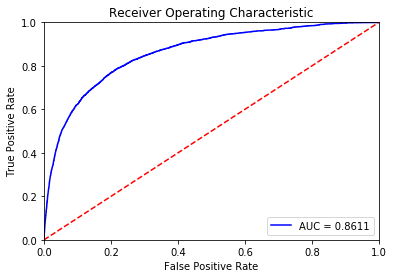

In [92]:
from sklearn.ensemble import RandomForestClassifier

max_depth = 8
no_trees = 150

rfc = RandomForestClassifier(n_estimators=no_trees, random_state=random_seed, max_depth=max_depth)
rfc = train_and_eval(rfc, X_train, X_test, y_train, y_test)

### 2.3: Logistic regression

Model trained!
THRESHOLD: 0.2
P: 0.28, R: 0.333, F1: 0.304
-------
THRESHOLD: 0.3
P: 0.366, R: 0.195, F1: 0.254
-------
THRESHOLD: 0.4
P: 0.467, R: 0.122, F1: 0.193
-------
THRESHOLD: 0.5
P: 0.515, R: 0.079, F1: 0.137
-------
THRESHOLD: 0.6
P: 0.534, R: 0.053, F1: 0.096
-------
THRESHOLD: 0.7
P: 0.506, R: 0.03, F1: 0.057
-------
THRESHOLD: 0.8
P: 0.478, R: 0.011, F1: 0.021
-------


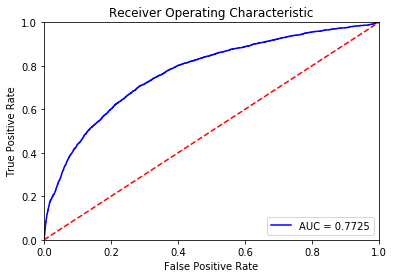

In [93]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver="lbfgs", random_state=random_seed)
lr = train_and_eval(lr, X_train, X_test, y_train, y_test)

In [70]:
#!pip install xgboost

You should consider upgrading via the 'pip install --upgrade pip' command.


### 2.4: Extreme gradient boosting

Model trained!
THRESHOLD: 0.2
P: 0.383, R: 0.501, F1: 0.434
-------
THRESHOLD: 0.3
P: 0.448, R: 0.383, F1: 0.413
-------
THRESHOLD: 0.4
P: 0.504, R: 0.29, F1: 0.368
-------
THRESHOLD: 0.5
P: 0.547, R: 0.202, F1: 0.295
-------
THRESHOLD: 0.6
P: 0.578, R: 0.131, F1: 0.214
-------
THRESHOLD: 0.7
P: 0.634, R: 0.073, F1: 0.131
-------
THRESHOLD: 0.8
P: 0.656, R: 0.029, F1: 0.055
-------


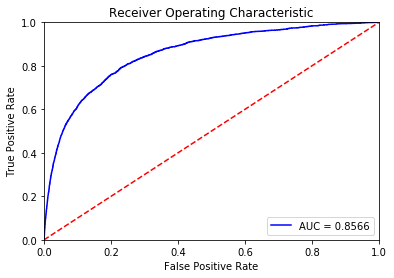

In [94]:
import xgboost as xgb

xgb_c = xgb.XGBClassifier(n_jobs=-1, random_state=random_seed)
xgb_c = train_and_eval(xgb_c, X_train, X_test, y_train, y_test)

## 2.5: Ensemble model

An ensemble of the Random Forest classifier and xgboost model had the highest ROC-AUC. Adding the logistic regression lowered the ROC score slightly to 0.8516, so it was removed. 

Model trained!
THRESHOLD: 0.2
P: 0.395, R: 0.507, F1: 0.444
-------
THRESHOLD: 0.3
P: 0.461, R: 0.381, F1: 0.417
-------
THRESHOLD: 0.4
P: 0.519, R: 0.272, F1: 0.357
-------
THRESHOLD: 0.5
P: 0.58, R: 0.181, F1: 0.276
-------
THRESHOLD: 0.6
P: 0.636, R: 0.098, F1: 0.17
-------
THRESHOLD: 0.7
P: 0.707, R: 0.039, F1: 0.075
-------
THRESHOLD: 0.8
P: 0.581, R: 0.006, F1: 0.012
-------


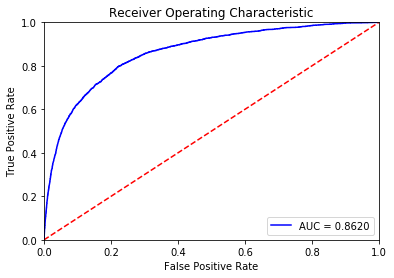

In [96]:
from sklearn.ensemble import VotingClassifier

estimators = [("rf", rfc), 
             ("xgb", xgb_c)]
vc = VotingClassifier(estimators, voting='soft')
vc = train_and_eval(vc, X_train, X_test, y_train, y_test)

### TBC: Error Analysis